# Event-study

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import wrds
import re
import matplotlib.pyplot as plt
import numpy as np
import re
from cleanco import basename
from tqdm.notebook import tqdm
import dask
dask.config.set(scheduler="processes")
from tqdm.dask import TqdmCallback
from linearmodels.system import SUR
import seaborn as sns
#sns.set(rc={'figure.figsize':(16,8)})
import plotly.graph_objects as go
from collections import OrderedDict
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.ticker as mtick

In [3]:
#import functions from functions.py
from function_definitions import *

# STEP 1 : estimate alpha and betas wrt CAPM and FF models

## a) $R_i^e = \alpha_i +\beta_i^M R_M^e + \beta_i^S R_{SMB}^e + \beta_i^H R_{HML}^e+\sum AR_{event_k}1_{event_k}$
## b) $R_i^e = \alpha_i +\sum AR_{event_k}1_{event_k}$  (zero-benchmark)
## matrix notation: $R_i^e = X \beta_i $

### $ \begin{bmatrix} R_{i,1}^e \\ ... \\ R_{i,m}^e \end{bmatrix} = \begin{bmatrix} 1 & R_{M,1}^e & R_{SMB,1}^e & R_{HML,1}^e & 0 & 0 & 0 & ... & 0\\ 1 & R_{M,1}^e & R_{SMB,1}^e & R_{HML,1}^e & 1 & 0 & 0 & ...& 0 \\  1 & R_{M,3}^e &  R_{SMB,3}^e & R_{HML,3}^e & 0 & 1 & 0 & ... & 0 \\  1 & R_{M,4}^e &  R_{SMB,4}^e & R_{HML,4}^e & 0 & 0 & 1 & ... & 0 \\... & ... & ... & ... & ... & ... & ... & ... \\ 1 & R_{M,m}^e & R_{SMB,m}^e & R_{HML,m}^e & 0 & 0 & 0 &... & 0 \end{bmatrix} \begin{bmatrix} \alpha_i \\ \beta_i^M \\ \beta_i^S \\ \beta_i^H \\ AR_{event_0} \\ ... \\ AR_{event_k} \end{bmatrix}$  

###  m = number of days in the whole period, k = number of events pertaining to firm i  

### use seemingly unrelated regressions: 

### $ \begin{bmatrix} R_{1}^e \\ R_2^e \\ ... \\ R_{n}^e \end{bmatrix} = \begin{bmatrix} X & 0 & ... & 0 \\ 0 & X & ... & 0\\ ... & & ... & ... \\  0 & 0 & ... &  X \end{bmatrix} \begin{bmatrix} \beta_1 \\ \beta_2 \\ ... \\ \beta_n \\ AR_{event_0} \\ ... \\ AR_{event_k} \end{bmatrix} + \begin{bmatrix} \epsilon_1 \\ \epsilon_2 \\ ... \\ \epsilon_n \end{bmatrix}$  

In [4]:
#load returns
returns = pd.read_csv('../data/event_study/excess_returns.csv', index_col = 'date')
returns.index = pd.to_datetime(returns.index)

#load refinitiv data
refinitiv_data = pd.read_csv('../data/event_study/refinitiv_data.csv')
refinitiv_data.Date_day = pd.to_datetime(refinitiv_data.Date_day)
#load market caps
mkt_caps = pd.read_csv('../data/event_study/market_caps.csv', index_col = 'date')
mkt_caps.index = pd.to_datetime(mkt_caps.index)
#load the event dataframe
event_df = pd.read_csv('../data/event_study/event_df.csv', index_col = 'date')
event_df.index = pd.to_datetime(event_df.index)

In [5]:
#Factor returns
FF5 = pd.read_csv('../data/FF_factors/FF5_daily.csv',skiprows = 3, index_col = 0).astype(float)
FF5 = FF5/100 # in percent?????
FF5.index.rename('date', inplace = True)
FF5.index = pd.to_datetime(FF5.index, format = '%Y%m%d')
momentum = pd.read_csv('../data/FF_factors/Momentum_daily.csv',skiprows = 13, index_col = 0)[:-1].astype(float)
momentum = momentum/100 # in percent?????
momentum.index.rename('date', inplace = True)
momentum.index = pd.to_datetime(momentum.index, format = '%Y%m%d')
momentum.columns = ['UMD']
FF5 = FF5.merge(momentum,left_index = True,right_index = True)

In [6]:
#build the indicator vectors for each event of each firm
event_indicator = {}
indexing_date = {}
indexing_index = {}
nb_events_dropped_mkt_cap = 0
nb_events_dropped_large_day_delta = 0
nb_events_dropped_exception  = 0
total_events = 0
not_dropped = 0

for firm in tqdm(returns.columns, desc = 'Building event indicator vectors'):
    events = refinitiv_data[refinitiv_data.CUSIP == firm].Date_day.values
    precise_events = refinitiv_data[refinitiv_data.CUSIP == firm].Date.values
    nb_events = len(events)

    df = pd.DataFrame(np.zeros([returns.shape[0],nb_events*11]), index = returns.index,
                      columns = [f"event{i//11}_day{(i%11)-5:+}" for i in range(nb_events*11)])
    
    retained = []
    closest_indexes = []
    for i,event in enumerate(events):
        event = pd.to_datetime(event)
        
        if firm == '30303M10' and i == 9:
            closest_indexes.append(None)
            continue #overlaps with another cyber event
        
        total_events += 1
        
        #the day of the event could be a holiday or weekend,
        #hence find the first trading day after the event and use
        #a 3 day window around that day
        timedelta = (event-df.index)
        try:
            closest_index = min((j for j, td in enumerate(timedelta) if td.total_seconds() <= 0))
                                 #key=lambda j: abs(timedelta[j].total_seconds()))
            
                
            #if after trading hours, take the next day
            if pd.to_datetime(precise_events[i]).hour > 16:
                closest_index +=1
            
            #do not consider events pertaining to low mkt cap firms
            if mkt_caps[firm].iloc[closest_index] < 300e6:
                nb_events_dropped_mkt_cap += 1 
                closest_indexes.append(None)
                continue
            
            #drop if the window is larger than 5 days
            nb_actual_days = (df.index[closest_index+1]-df.index[closest_index-1]).days+1
            if nb_actual_days > 5:
                nb_events_dropped_large_day_delta += 1
                closest_indexes.append(None)
                continue

            #3 vectors per event with a single one each
            df.iloc[closest_index,   i*11+5] = 1 #event day
            df.iloc[closest_index-1, i*11+4] = 1
            df.iloc[closest_index+1, i*11+6] = 1
            
            #extra window for analysis
            df.iloc[closest_index-2, i*11+3] = 1
            df.iloc[closest_index-3, i*11+2] = 1
            df.iloc[closest_index-4, i*11+1] = 1
            df.iloc[closest_index-5, i*11] = 1
            
            df.iloc[closest_index+2, i*11+7] = 1
            df.iloc[closest_index+3, i*11+8] = 1
            df.iloc[closest_index+4, i*11+9] = 1
            df.iloc[closest_index+5, i*11+10] = 1
            
            closest_indexes.append(closest_index)
            retained.append(i)
            
            not_dropped +=1
            
        except:
            closest_indexes.append(None)
            nb_events_dropped_exception +=1
            if event.year != 2023:
                firm_ = firm
                event_ = event
            
            
    # Drop the columns with all zeros
    zero_columns = df.columns[(df == 0).all()]
    df = df.drop(columns=zero_columns)
    
    if df.shape[1] == 0:
        event_indicator[firm] = []
    else:
        event_indicator[firm] = df
    indexing_date[firm] = [date if index in retained else None for index, date in enumerate(events)]
    indexing_index[firm] = closest_indexes

nb_events_step3 = not_dropped

Building event indicator vectors:   0%|          | 0/116 [00:00<?, ?it/s]

### Seemingly Unrelated Regression

In [7]:
#load the optimal sample parameters
optimal_sample = pd.read_csv('../data/event_study/optimal_sample.csv', index_col = 0)
x_ = optimal_sample.loc['sample_start','idx']
y_ = optimal_sample.loc['sample_end','idx']

In [8]:
SUR_data = OrderedDict()
FF3_factors = ['Mkt-RF','HML','SMB']

exog_ = {}
nb_events_end = 0
shapes = []

for firm in returns.columns:
    dependent = returns[firm].iloc[x_:y_].dropna()
    shapes.append(dependent.shape[0])
    
    #drop firms that don't have all observations 
    #(exog and dependent have to be the same length for all regressions)
    if dependent.shape[0] != y_-x_:
        continue
    
    exog = sm.add_constant(FF5.loc[dependent.index, FF3_factors])
    if len(event_indicator[firm]):
        event_vectors = event_indicator[firm].loc[dependent.index,:]
        zero_columns = event_vectors.columns[(event_vectors == 0).all()]
        event_vectors = event_vectors.drop(columns=zero_columns)
        nb_events_end += event_vectors.shape[1]/11
        
        exog = pd.concat([exog, event_vectors], axis = 1)
    
    if exog.shape[1] > 4:
        SUR_data[firm] = {"dependent" : dependent, "exog" : exog}
        exog_[firm] = exog

In [9]:
#stats
nb_firms_end = len(SUR_data)
print(f'{nb_events_end:.0f} events relating to {nb_firms_end} firms.')

126 events relating to 47 firms.


In [10]:
#fit SUR model
model = SUR(SUR_data)
res = model.fit()

In [11]:
#correlation matrix of residuals
resid_corr = res.resids.corr()

#cross_correlations (upper triangle)
cross_corrs = resid_corr.where(np.triu(np.ones(res.resids.corr().shape),k = 1).astype(bool))

#mean cross-correlation of residuals
r = np.nanmean(cross_corrs)

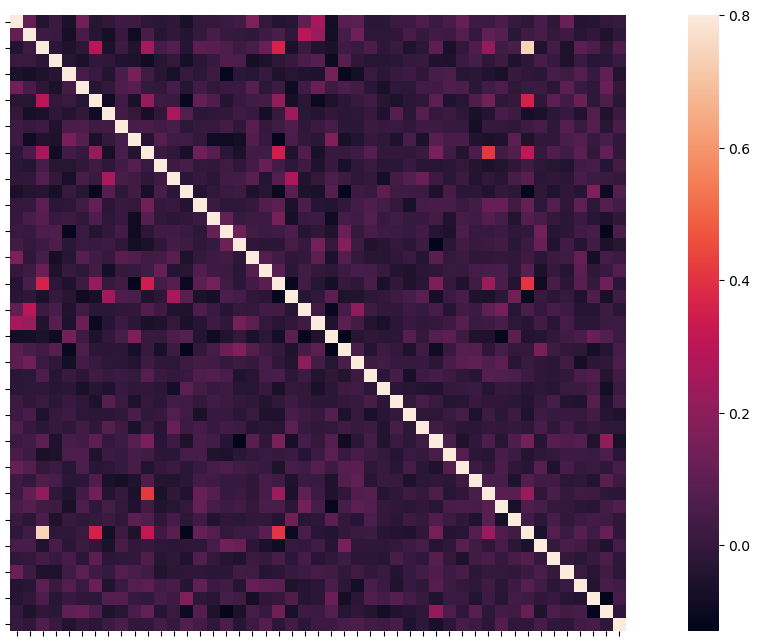

The average cross-correlation of residuals is 0.012


In [12]:
plt.figure(figsize = (16,8))
ax = sns.heatmap(resid_corr,vmax=0.8,  square=True)
ax.set(xticklabels=[], yticklabels = [])
plt.show()

print(f'The average cross-correlation of residuals is {round(r,3)}')

# STEP 2 : test the significance of the mean CAR

## scaled abnormal returns: $A_{i,t} = \frac{AR_{i,t}}{s_i \sqrt{1+ x_t'(X'X)^{-1}x_t}}$  
### $s_i$ is residual standard deviation (from step 1?), X is the matrix of explanatory variable values (from step 1?) and $x_t$ is vector of explanatory variable values on event day t (row t of X?)

## feasible estimator of the variance of A: $s_A^2 = \frac{s^2}{1-\bar{r}}$
### $s^2$ is the sample cross-sectional variance of event-day scaled abnormal returns and $\bar{r}$ the average sample cross-correlation of the residuals (from step 1?)

# ADJ BMP t-statistic: $t_{AB} =  \frac{\bar{A} \sqrt{n}}{s_A \sqrt{1+(n-1)\bar{r}}} \sim N(0,1)?$   
### n is the number of firms
## same formula for CARs but replace $\bar{A}$ with the scaled cumulative abnormal returns and $s_A$ with the cross-sectional standard deviation of SCARs

# ADJ PATELL t-statistic: $t_{AB} =  \frac{\bar{A} \sqrt{n}}{\sqrt{(m-p-1)/(m-p-3)}\sqrt{1+(n-1)\bar{r}}} \sim N(0,1)?$   
### p is the number of explanatory variables in the expected return regression
### m = number of days in the whole period

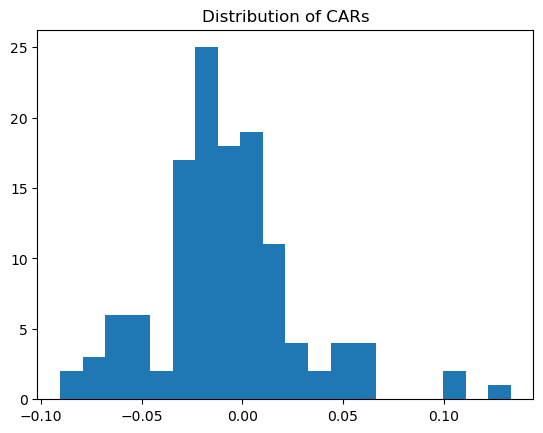

Mean CAR = -0.78%
t-stat = -2.434 and p value = 0.016


In [13]:
#abnormal return
AR = res.params.T.filter(like = 'event')
AR = AR.reset_index()
AR[['CUSIP', 'event', 'day']] = AR['index'].str.extract(r'(.+)_event(\d+)_day(.+)')

AR['t'] = np.nan
for firm in AR.CUSIP.unique():
    
    ts = [value-x_ for i,value in enumerate(indexing_index[firm]) if (value is not None)
          and (indexing_date[firm][i] >= returns.index[x_]) 
          and (indexing_date[firm][i] <= returns.index[y_])]
    for day in ['-5','-4','-3','-2','-1','+0','+1','+2','+3','+4','+5']:
        AR.loc[(AR.CUSIP == firm) & (AR.day == day),'t'] = ts

#cumulative abnormal return
CAR = AR[AR.day.isin(['-1','+0','+1'])].groupby(['CUSIP','event']).params.apply(cumulate_returns)
plt.hist(CAR, bins = 20)
plt.title('Distribution of CARs')
plt.show()
print(f'Mean CAR = {CAR.mean():.2%}')
stat = sm.OLS(CAR.values,np.ones(len(CAR.values))).fit()
print(f't-stat = {round(stat.tvalues[0],3)} and p value = {round(stat.pvalues[0],3)}')

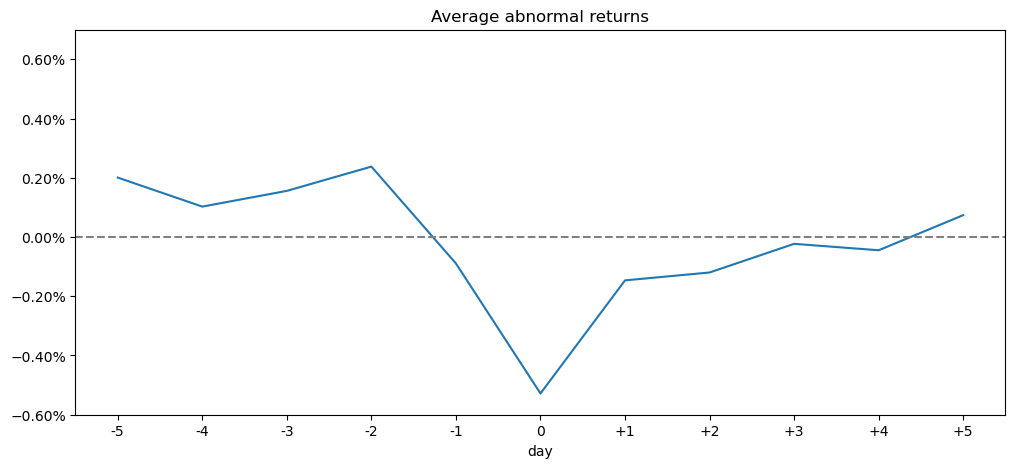

In [14]:
mean_daily_AR = AR.groupby('day').mean().params.loc[['-5','-4','-3','-2','-1','+0','+1','+2','+3','+4','+5']]
mean_daily_AR *= 100
ax = mean_daily_AR.plot(figsize = (12,5))
plt.ylim([-0.6,0.7])
plt.xticks(range(0,11),['-5','-4','-3','-2','-1','0','+1','+2','+3','+4','+5'])
plt.axhline(0, color='gray', linestyle='--')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Average abnormal returns')
plt.show()

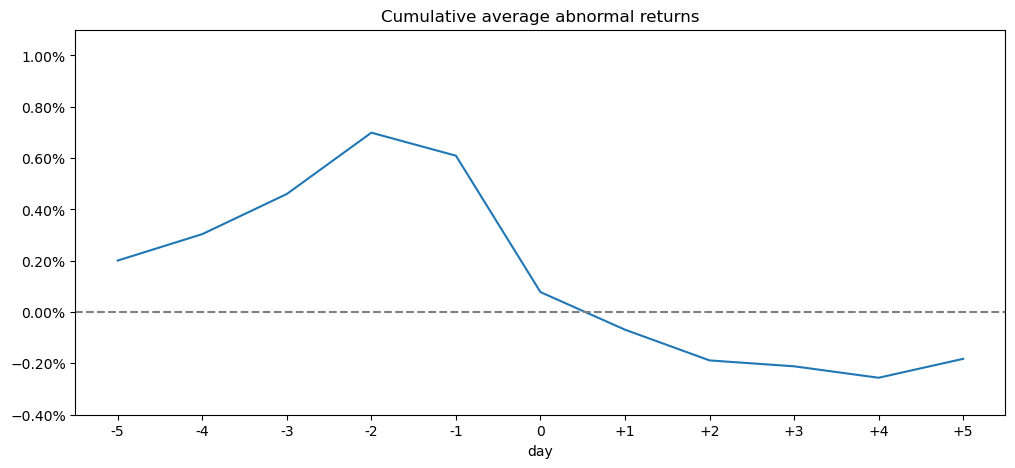

In [15]:
cum_mean_daily_AR = (AR.groupby('day').mean().params+1)
cum_mean_daily_AR = cum_mean_daily_AR.loc[['-5','-4','-3','-2','-1','+0','+1','+2','+3','+4','+5']]
cum_mean_daily_AR = cum_mean_daily_AR.cumprod()-1
cum_mean_daily_AR *= 100
ax = cum_mean_daily_AR.plot(figsize = (12,5))
plt.ylim([-0.4,1.1])
plt.xticks(range(0,11),['-5','-4','-3','-2','-1','0','+1','+2','+3','+4','+5'])
plt.axhline(0, color='gray', linestyle='--')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Cumulative average abnormal returns')
plt.show()

In [16]:
#regression residual standard deviation
s = res.resids.std()
SAR = {}

for firm in tqdm(SUR_data.keys(), desc = 'Computing SARs'):
    si = s[firm]
    
    X = exog_[firm]
    
    SAR[firm] = pd.DataFrame(np.ones(X.shape[0])*np.nan, index = X.index)
    
    ts = [value-x_ for i,value in enumerate(indexing_index[firm]) if (value is not None)
          and (indexing_date[firm][i] >= returns.index[x_]) 
          and (indexing_date[firm][i] <= returns.index[y_])]
    
    for t in ts:
        for day in ['-1','+0','+1']:
            x = X.iloc[t+int(day)]
    
            #correction term
            d = x.T @ np.linalg.inv(X.T @ X) @ x
        
            ARit = AR[(AR.CUSIP == firm)  & (AR.day == day) & (AR.t == t)].params.values[0]
        
            SAR[firm].loc[X.index[t+int(day)], :] = ARit/(si*np.sqrt(1+d))

SAR = pd.concat(SAR, axis = 1)
SAR.columns = SAR.columns.get_level_values(0)

Computing SARs:   0%|          | 0/47 [00:00<?, ?it/s]

In [17]:
#compute SCARs
SCAR = SAR.apply(product_of_consecutive_non_nulls)

#mean 
SCAR_mean = SCAR.explode().mean()

#cross-sectional standard deviation of SCARs
sa = np.sqrt(SCAR.explode().var()/(1-r))

#number of firms
n = len(SUR_data.keys())

#ADJ-BMP test statistic

ADJ_BMP = (SCAR_mean*np.sqrt(n))/(sa*np.sqrt(1+(n-1)*r))
print(f'ADJ-BMP = {round(ADJ_BMP,3)}')

p_value = 2 * (1 - stats.norm.cdf(abs(ADJ_BMP)))
print(f'p value = {round(p_value,3)}')
print('\n')

m = y_-x_
p = 3 #nb of explanatory variables in the expected return regression

#ADJ-PATELL test statistic
ADJ_PATELL = (SCAR_mean*np.sqrt(n))/(np.sqrt((m-p-1)/(m-p-3))*np.sqrt(1+(n-1)*r))
print(f'ADJ-PATELL = {round(ADJ_PATELL,3)}')

p_value = 2 * (1 - stats.norm.cdf(abs(ADJ_PATELL)))
print(f'p value = {round(p_value,3)}')

ADJ-BMP = -1.037
p value = 0.3


ADJ-PATELL = -1.811
p value = 0.07


In [18]:
#save data
CAR.to_csv('../data/event_study/CAR_SURE.csv')
AR.to_csv('../data/event_study/AR_SURE.csv', index = False)

## Zero benchmark regression

In [19]:
SUR_data = OrderedDict()

exog_ = {}
nb_events_end = 0
shapes = []

for firm in returns.columns:
    dependent = returns[firm].iloc[x_:y_].dropna()
    shapes.append(dependent.shape[0])
    
    #drop firms that don't have all observations 
    #(exog and dependent have to be the same length for all regressions)
    if dependent.shape[0] != y_-x_:
        continue
    
    exog = pd.DataFrame()
    if len(event_indicator[firm]):
        event_vectors = event_indicator[firm].loc[dependent.index,:]
        zero_columns = event_vectors.columns[(event_vectors == 0).all()]
        event_vectors = event_vectors.drop(columns=zero_columns)
        nb_events_end += event_vectors.shape[1]/11
        
        exog = sm.add_constant(event_vectors)
    
    if exog.shape[1] > 1:
        SUR_data[firm] = {"dependent" : dependent, "exog" : exog}
        exog_[firm] = exog

In [20]:
#stats
nb_firms_end = len(SUR_data)
print(f'{nb_events_end:.0f} events relating to {nb_firms_end} firms.')

126 events relating to 47 firms.


In [21]:
#fit SUR model
model = SUR(SUR_data)
res = model.fit()

In [22]:
#correlation matrix of residuals
resid_corr = res.resids.corr()

#cross_correlations (upper triangle)
cross_corrs = resid_corr.where(np.triu(np.ones(res.resids.corr().shape),k = 1).astype(bool))

#mean cross-correlation of residuals
r = np.nanmean(cross_corrs)

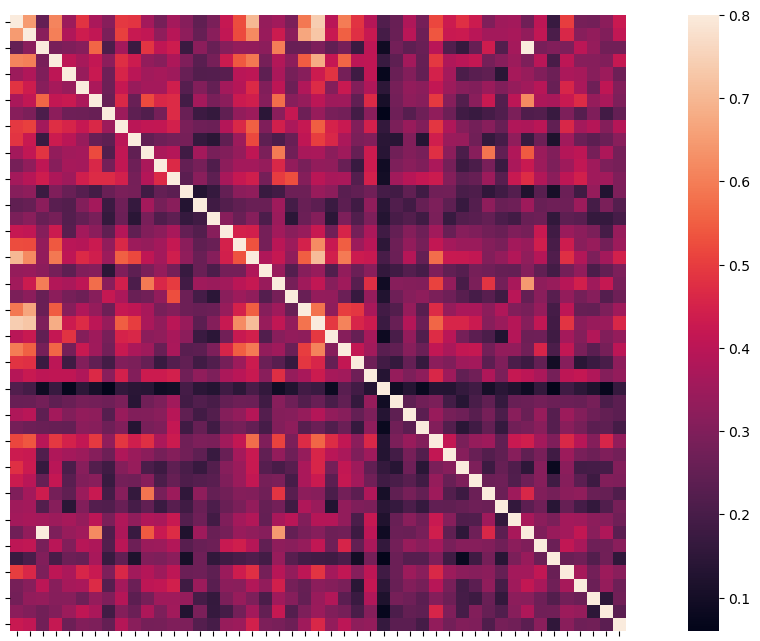

The average cross-correlation of residuals is 0.315


In [23]:
plt.figure(figsize = (16,8))
ax = sns.heatmap(resid_corr,vmax=0.8,  square=True)
ax.set(xticklabels=[], yticklabels = [])
plt.show()

print(f'The average cross-correlation of residuals is {round(r,3)}')

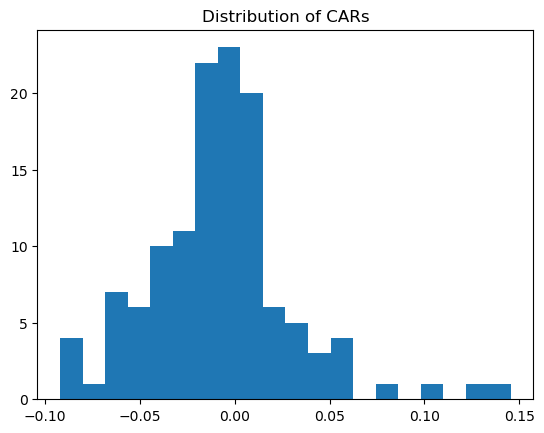

Mean CAR = -0.79%
t-stat = -2.325 and p value = 0.022


In [24]:
#abnormal return
AR = res.params.T.filter(like = 'event')
AR = AR.reset_index()
AR[['CUSIP', 'event', 'day']] = AR['index'].str.extract(r'(.+)_event(\d+)_day(.+)')

AR['t'] = np.nan
for firm in AR.CUSIP.unique():
    
    ts = [value-x_ for i,value in enumerate(indexing_index[firm]) if (value is not None)
          and (indexing_date[firm][i] >= returns.index[x_]) 
          and (indexing_date[firm][i] <= returns.index[y_])]
    for day in ['-5','-4','-3','-2','-1','+0','+1','+2','+3','+4','+5']:
        AR.loc[(AR.CUSIP == firm) & (AR.day == day),'t'] = ts

#cumulative abnormal return
CAR = AR[AR.day.isin(['-1','+0','+1'])].groupby(['CUSIP','event']).params.apply(cumulate_returns)
plt.hist(CAR, bins = 20)
plt.title('Distribution of CARs')
plt.show()
print(f'Mean CAR = {CAR.mean():.2%}')
stat = sm.OLS(CAR.values,np.ones(len(CAR.values))).fit()
print(f't-stat = {round(stat.tvalues[0],3)} and p value = {round(stat.pvalues[0],3)}')

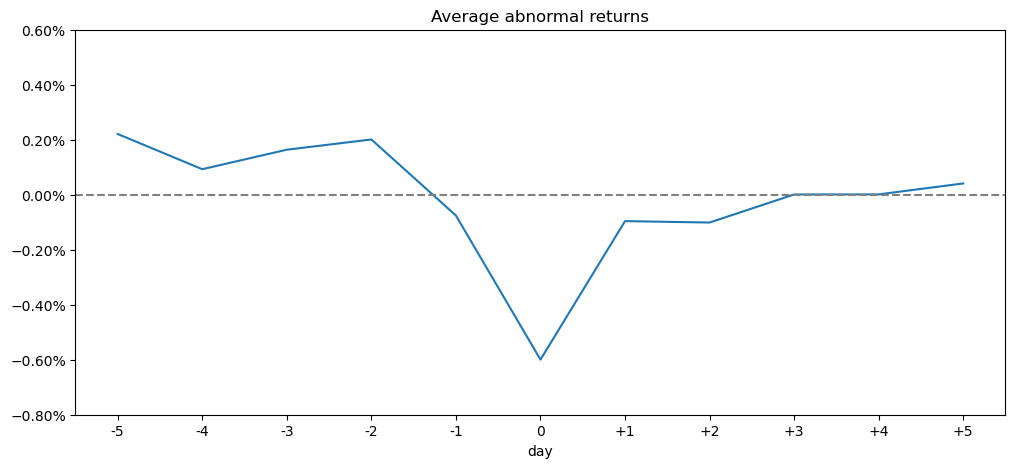

In [25]:
mean_daily_AR = AR.groupby('day').mean().params.loc[['-5','-4','-3','-2','-1','+0','+1','+2','+3','+4','+5']]
mean_daily_AR *= 100
ax = mean_daily_AR.plot(figsize = (12,5))
plt.ylim([-0.8,0.6])
plt.xticks(range(0,11),['-5','-4','-3','-2','-1','0','+1','+2','+3','+4','+5'])
plt.axhline(0, color='gray', linestyle='--')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Average abnormal returns')
plt.show()

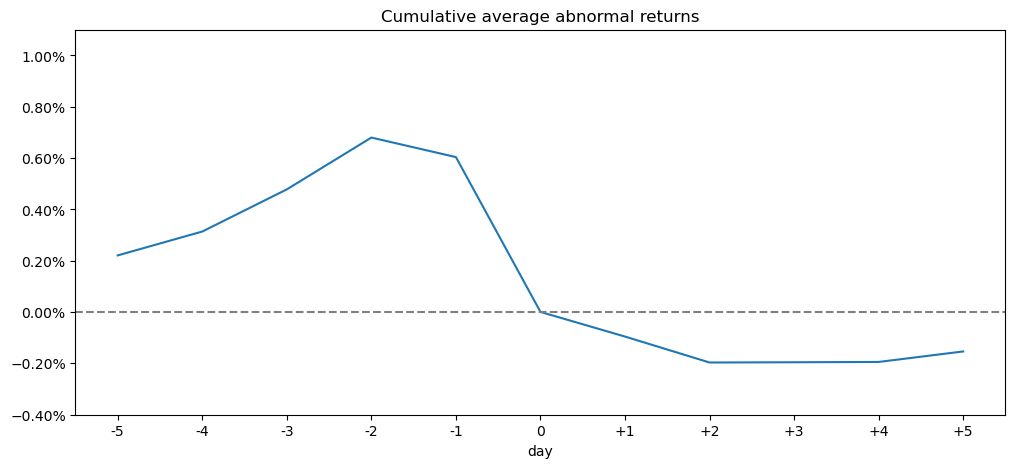

In [26]:
cum_mean_daily_AR = (AR.groupby('day').mean().params+1)
cum_mean_daily_AR = cum_mean_daily_AR.loc[['-5','-4','-3','-2','-1','+0','+1','+2','+3','+4','+5']]
cum_mean_daily_AR = cum_mean_daily_AR.cumprod()-1
cum_mean_daily_AR *= 100
ax = cum_mean_daily_AR.plot(figsize = (12,5))
plt.ylim([-0.4,1.1])
plt.xticks(range(0,11),['-5','-4','-3','-2','-1','0','+1','+2','+3','+4','+5'])
plt.axhline(0, color='gray', linestyle='--')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Cumulative average abnormal returns')
plt.show()

In [27]:
#regression residual standard deviation
s = res.resids.std()
SAR = {}

for firm in tqdm(SUR_data.keys(), desc = 'Computing SARs'):
    si = s[firm]
    
    X = exog_[firm]
    
    SAR[firm] = pd.DataFrame(np.ones(X.shape[0])*np.nan, index = X.index)
    
    ts = [value-x_ for i,value in enumerate(indexing_index[firm]) if (value is not None)
          and (indexing_date[firm][i] >= returns.index[x_]) 
          and (indexing_date[firm][i] <= returns.index[y_])]
    
    for t in ts:
        for day in ['-1','+0','+1']:
            x = X.iloc[t+int(day)]
    
            #correction term
            d = x.T @ np.linalg.inv(X.T @ X) @ x
        
            ARit = AR[(AR.CUSIP == firm)  & (AR.day == day) & (AR.t == t)].params.values[0]
        
            SAR[firm].loc[X.index[t+int(day)], :] = ARit/(si*np.sqrt(1+d))

SAR = pd.concat(SAR, axis = 1)
SAR.columns = SAR.columns.get_level_values(0)

Computing SARs:   0%|          | 0/47 [00:00<?, ?it/s]

In [28]:
#compute SCARs
SCAR = SAR.apply(product_of_consecutive_non_nulls)

#mean 
SCAR_mean = SCAR.explode().mean()

#cross-sectional standard deviation of SCARs
sa = np.sqrt(SCAR.explode().var()/(1-r))

#number of firms
n = len(SUR_data.keys())

#ADJ-BMP test statistic

ADJ_BMP = (SCAR_mean*np.sqrt(n))/(sa*np.sqrt(1+(n-1)*r))
print(f'ADJ-BMP = {round(ADJ_BMP,3)}')

p_value = 2 * (1 - stats.norm.cdf(abs(ADJ_BMP)))
print(f'p value = {round(p_value,3)}')
print('\n')

m = y_-x_
p = 3 #nb of explanatory variables in the expected return regression

#ADJ-PATELL test statistic
ADJ_PATELL = (SCAR_mean*np.sqrt(n))/(np.sqrt((m-p-1)/(m-p-3))*np.sqrt(1+(n-1)*r))
print(f'ADJ-PATELL = {round(ADJ_PATELL,3)}')

p_value = 2 * (1 - stats.norm.cdf(abs(ADJ_PATELL)))
print(f'p value = {round(p_value,3)}')

ADJ-BMP = -0.273
p value = 0.785


ADJ-PATELL = -0.455
p value = 0.649


In [152]:
#save data
CAR.to_csv('../data/event_study/CAR_SURE_0B.csv')
AR.to_csv('../data/event_study/AR_SURE_0B.csv', index = False)

In [38]:
refi_copy = refinitiv_data.copy()
indexes = []
for firm in CAR.index.get_level_values(0).unique():
    for event in CAR[[firm]].index.get_level_values(1).astype(int).unique():
        indexes.append(refi_copy[refi_copy.CUSIP == firm].iloc[[event]].index[0])
#refinitiv_data.loc[indexes,:].to_csv('end_data_refinitiv.csv')